# Hans 2024 data v2

Let's take a look at the perplexity ratio score data generated with the v2 scoring algorithm.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load the scored text fragment data from the Hans 2024 corpus.

In [2]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/falcon-7b_scores_v2.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Enforce dtypes
data_df = data_df.astype({
    'Source record num': int,
    'Fragment length (words)': int,
    'Fragment length (tokens)': int,
    'Dataset': str,
    'Source': str,
    'String': str,
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float,
    'Reader time (seconds)': float,
    'Writer time (seconds)': float,
    'Reader peak memory (GB)': float,
    'Writer peak memory (GB)': float
})

# get rid of some unnecessary columns
data_df.drop([
    'Source record num', 
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
], axis = 1, inplace = True)

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7427 entries, 0 to 7426
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   7427 non-null   int64  
 1   Fragment length (tokens)  7427 non-null   int64  
 2   Dataset                   7427 non-null   object 
 3   Source                    7427 non-null   object 
 4   String                    7427 non-null   object 
 5   Perplexity                7427 non-null   float64
 6   Cross-perplexity          7427 non-null   float64
 7   Perplexity ratio score    7427 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 464.3+ KB


Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 3719 human text fragments and 3708 synthetic fragments.
Dataset is 49.9% synthetic fragments.


In [4]:
data_df.head()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
0,35,43,cnn,human,City60 model aimed at UK city dwellers in an a...,4.133,3.441406,1.200908
1,208,293,cc_news,human,Harvey Weinstein after turning himself to auth...,1.993,2.101562,0.948420
2,124,177,cc_news,synthetic,Critics have blasted Facebook for sharing the ...,2.234,2.599609,0.859504
3,102,143,cc_news,synthetic,defeats to the very same team last season?\nCi...,2.613,2.958984,0.883168
4,377,439,cc_news,synthetic,may have a relatively good notion of the evol...,1.954,2.566406,0.761416


In [5]:
data_df.tail()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
7422,11,11,cc_news,human,a foreign political party to raise serious all...,4.992,4.875000,1.024038
7423,21,25,cnn,synthetic,cap against Australia during the summer. Uncap...,4.027,3.890625,1.035141
7424,92,130,cc_news,synthetic,NCAA or international star as he blossomed on ...,2.170,2.513672,0.863248
7425,330,443,cc_news,synthetic,"set definition of an apple, but it’s used as a...",2.260,2.669922,0.846379
7426,321,432,cnn,synthetic,up for sale.\nAerial view of the mansion that ...,2.190,2.742188,0.798433


Make some plots with perplexity ratio score and related variables to what we have.

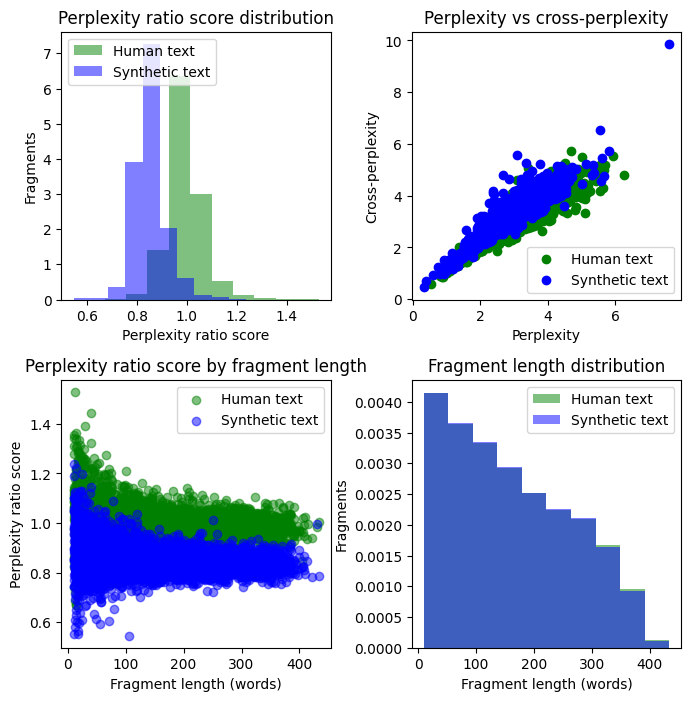

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (words)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (words)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (words)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (words)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (words)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (words)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [7]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 5942 training examples
Have 1485 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   1485 non-null   int64  
 1   Fragment length (tokens)  1485 non-null   int64  
 2   Dataset                   1485 non-null   object 
 3   Source                    1485 non-null   object 
 4   String                    1485 non-null   object 
 5   Perplexity                1485 non-null   float64
 6   Cross-perplexity          1485 non-null   float64
 7   Perplexity ratio score    1485 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 92.9+ KB


And finally, save the split data for future use.

In [8]:
# Save training data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())